<a href="https://colab.research.google.com/gist/AndriiVasylenkoML/f7c75a6d194619811523284b76b7b6d8/dl-eyeglasses-segmentation-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries
!pip install tensorflow
# Or if using PyTorch
# !pip install torch torchvision

# Additional libraries
!pip install matplotlib numpy opencv-python


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/MyDrive/datasets/eyeglasses_dataset.zip"

Archive:  /content/gdrive/MyDrive/datasets/eyeglasses_dataset.zip
   creating: eyeglasses_dataset/test/
   creating: eyeglasses_dataset/test/images/
  inflating: eyeglasses_dataset/test/images/58080_3_generated_0_00001_.png  
  inflating: eyeglasses_dataset/test/images/58162_2_generated_0_00001_.png  
  inflating: eyeglasses_dataset/test/images/58196_0_generated_0_00001_.png  
  inflating: eyeglasses_dataset/test/images/58208_1_generated_0_00001_.png  
  inflating: eyeglasses_dataset/test/images/58212_0_generated_1_00001_.png  
  inflating: eyeglasses_dataset/test/images/58219_1_generated_0_00001_.png  
  inflating: eyeglasses_dataset/test/images/58223_0_generated_0_00001_.png  
  inflating: eyeglasses_dataset/test/images/58234_0_generated_0_00001_.png  
  inflating: eyeglasses_dataset/test/images/58258_0_generated_0_00001_.png  
  inflating: eyeglasses_dataset/test/images/58277_1_generated_0_00001_.png  
   creating: eyeglasses_dataset/test/masks/
  inflating: eyeglasses_dataset/test/

## 1. Data Preparation (with Train-Validation Split)


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Function to load images and masks
def load_data(image_dir, mask_dir, img_size=(128, 128)):
    images = []
    masks = []
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, img_size)
        mask = cv2.resize(mask, img_size)

        image = image / 255.0
        mask = mask / 255.0
        mask = np.where(mask > 0.5, 1, 0)  # Convert mask to binary

        images.append(image)
        masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)

    masks = np.expand_dims(masks, axis=-1)  # Add channel dimension for masks

    return images, masks

## 3. Model Definition

In [ ]:
# Define advanced U-Net model with EfficientNetB0 backbone
# Function to load images and masks
def load_data(image_dir, mask_dir, img_size=(128, 128)):
    images = []
    masks = []
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, img_size)
        mask = cv2.resize(mask, img_size)

        image = image / 255.0
        mask = mask / 255.0
        mask = np.where(mask > 0.5, 1, 0)  # Convert mask to binary

        images.append(image)
        masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)

    masks = np.expand_dims(masks, axis=-1)  # Add channel dimension for masks

    return images, masks

# Define advanced U-Net model with EfficientNetB0 backbone
def advanced_unet(input_size=(128, 128, 3)):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_size)

    conv4 = base_model.get_layer('block6a_expand_activation').output
    conv3 = base_model.get_layer('block4a_expand_activation').output
    conv2 = base_model.get_layer('block3a_expand_activation').output
    conv1 = base_model.get_layer('block2a_expand_activation').output

    # Decoder
    up6 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv4))
    merge6 = concatenate([conv3, up6], axis=3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv2, up7], axis=3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv1, up8], axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(32, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(conv9)
    conv9 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=base_model.input, outputs=conv9)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    return model

## 2. Data Augmentation and Data Generators

In [ ]:
# Paths to the image and mask directories
image_dir = '/content/eyeglasses_dataset/train/images'
mask_dir = '/content/eyeglasses_dataset/train/masks'

In [ ]:
# Load dataset
images, masks = load_data(image_dir, mask_dir)

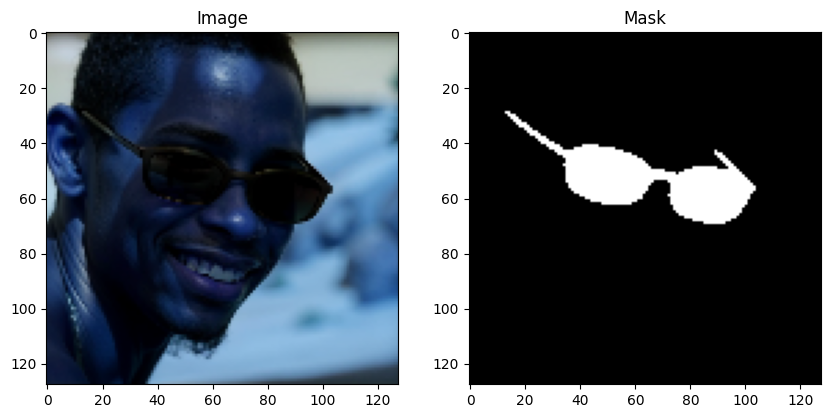

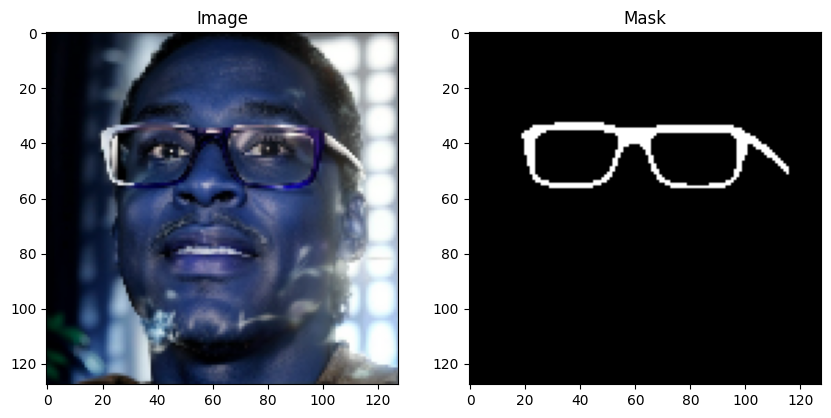

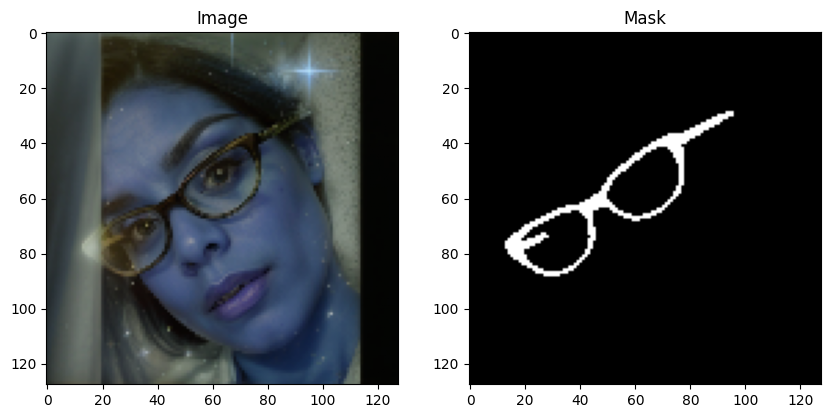

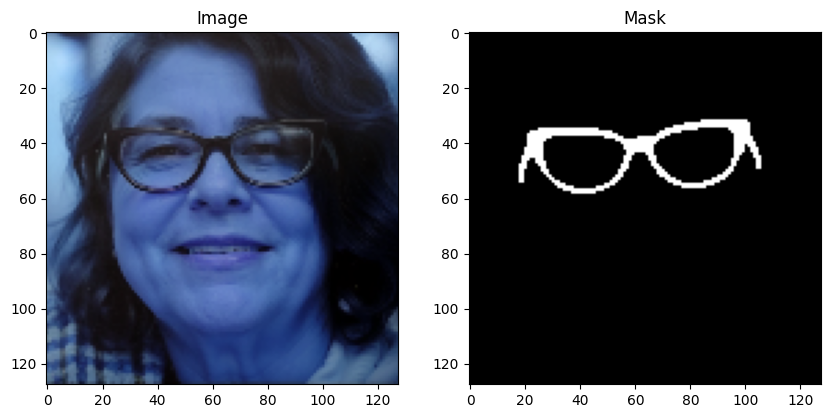

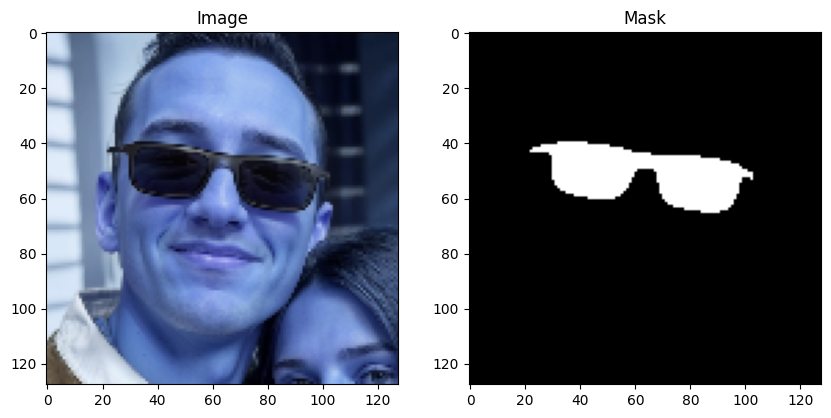

In [ ]:
# Visualize some images and masks to ensure correct preprocessing
def visualize_data(images, masks, num_samples=5):
    for i in range(num_samples):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Image")
        plt.imshow(images[i])
        plt.subplot(1, 2, 2)
        plt.title("Mask")
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.show()

visualize_data(images, masks)

In [ ]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

## 4. Training the Model

In [ ]:
# Fit the model
model = advanced_unet(input_size=(128, 128, 3))
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(X_val, y_val)
)

16705208/16705208 [==============================] - 2s 0us/step
Epoch 1/50
50/50 [==============================] - 68s 512ms/step - loss: 0.1788 - accuracy: 0.9617 - val_loss: 0.1712 - val_accuracy: 0.9633
Epoch 2/50
50/50 [==============================] - 14s 281ms/step - loss: 0.1114 - accuracy: 0.9639 - val_loss: 0.1157 - val_accuracy: 0.9633
Epoch 3/50
50/50 [==============================] - 14s 276ms/step - loss: 0.0986 - accuracy: 0.9639 - val_loss: 0.1133 - val_accuracy: 0.9633
Epoch 4/50
50/50 [==============================] - 14s 275ms/step - loss: 0.0960 - accuracy: 0.9641 - val_loss: 0.1178 - val_accuracy: 0.9633
Epoch 5/50
50/50 [==============================] - 15s 289ms/step - loss: 0.0939 - accuracy: 0.9660 - val_loss: 0.1038 - val_accuracy: 0.9633
Epoch 6/50
50/50 [==============================] - 15s 292ms/step - loss: 0.0922 - accuracy: 0.9668 - val_loss: 0.0998 - val_accuracy: 0.9633
Epoch 7/50
50/50 [==============================] - 14s 281ms/step - loss: 0.

In [ ]:
model.save('advanced_eyeglasses_segmentation_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 5. Evaluation and Benchmarking

In [ ]:
# Evaluate the model
predictions = model.predict(X_val)
predictions = np.where(predictions > 0.5, 1, 0)  # Apply threshold to predicted masks

13/13 [==============================] - 1s 62ms/step


## 6. Inference and Visualization

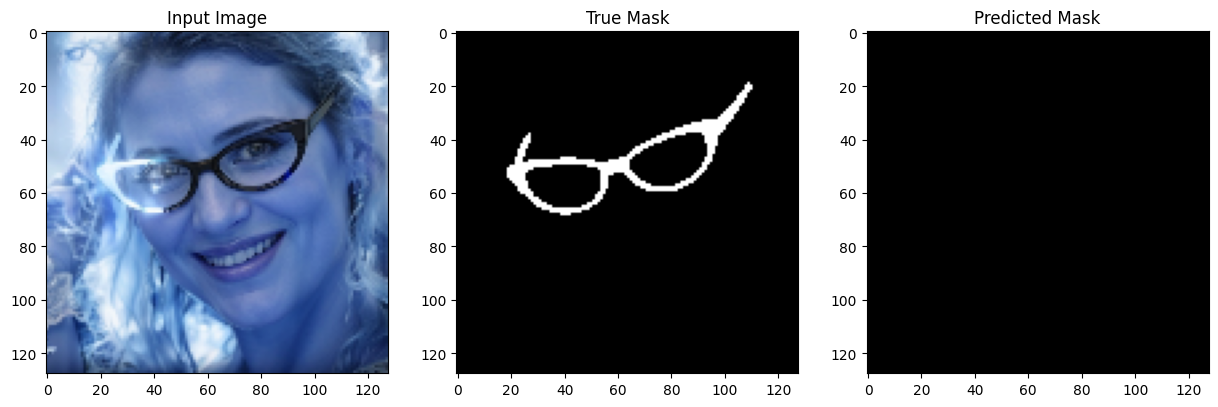

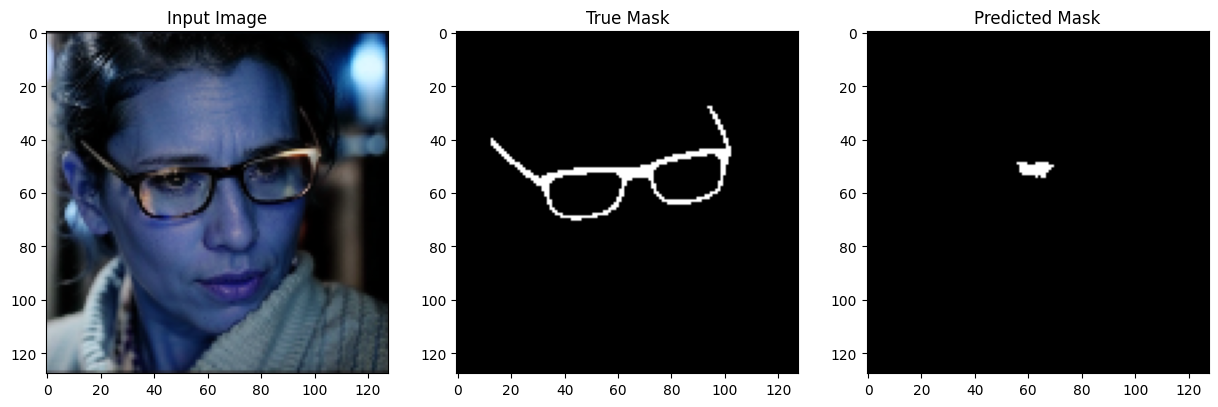

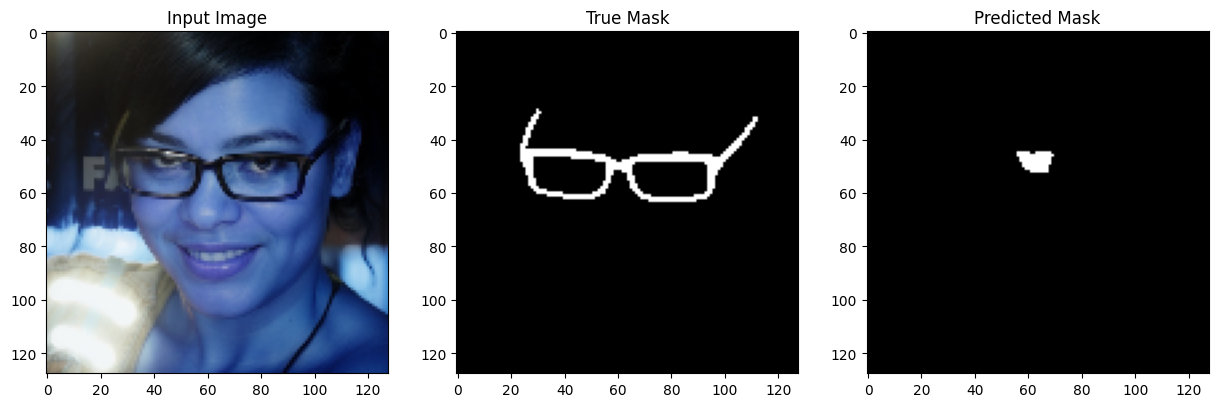

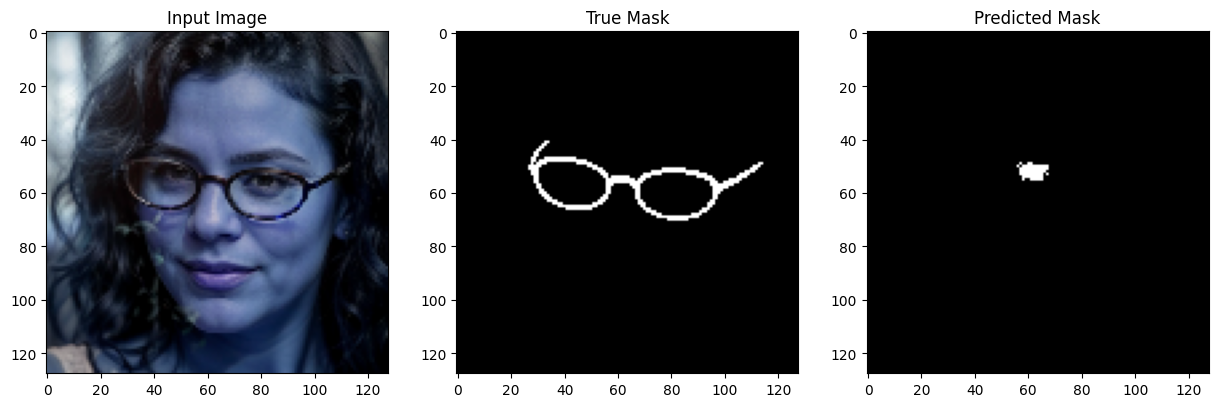

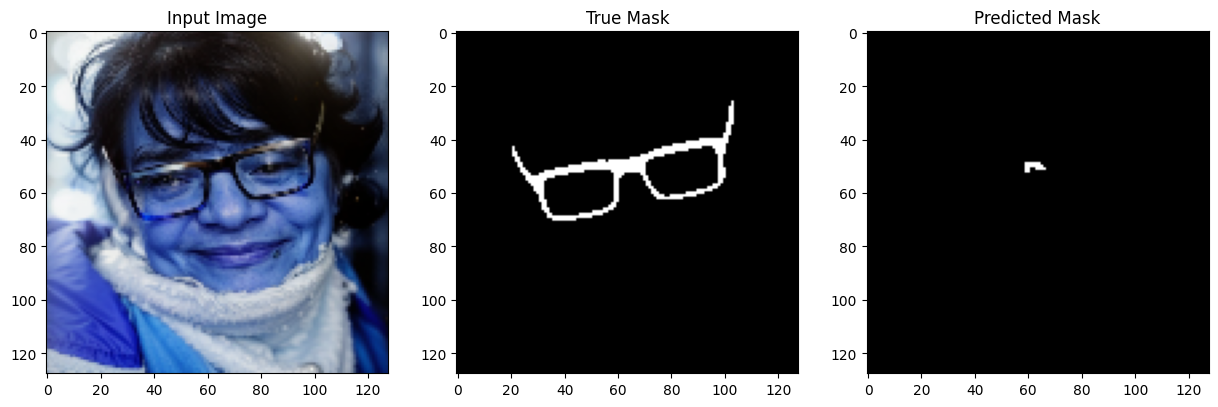

In [ ]:
# Visualization function
def visualize_predictions(images, true_masks, predicted_masks, num_samples=5):
    for i in range(num_samples):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(images[i])
        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(true_masks[i].squeeze(), cmap='gray')
        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(predicted_masks[i].squeeze(), cmap='gray')
        plt.show()

# Test the visualization function with a few examples
visualize_predictions(X_val[:5], y_val[:5], predictions[:5])

1.   chatgpt: https://chatgpt.com/share/24f223ac-f3c3-47aa-adeb-5171d144d13f